In [1]:
# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

In [2]:
# !pip install labelme

In [3]:
import json
from labelme.utils.shape import labelme_shapes_to_label

In [4]:
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
def checkpath(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
def get_dir_json_list(root_dir):
    jsons_files = []
    for json_N in os.listdir(root_dir):
        if json_N[-1] == 'n':
            jsons_files += [os.path.join(root_dir, json_N)]
    return jsons_files

In [7]:
def get_dict(root_dir):

    json_list = get_dir_json_list(root_dir)

    dict_all = {}
    for json_path in json_list:
        dir,file = os.path.split(json_path)
        file_name = file.split('.')[0]
        image_path = os.path.join(dir.replace('json', '') + 'jpg_CNN', file_name + '.jpg')
        dict_all[image_path] = json_path
    return dict_all

In [8]:
def kakunin_size(size):
  if size==1080:
    x = 420
    y = 0
    w = 1080
    h = 1080
  elif size==488:
    x = 116
    y = 0
    w = 488
    h = 488
  return x, y, w, h

In [9]:
def mask_process(masks_dir, error_list):
    dict_ = get_dict(masks_dir)

    for image_path in dict_:
        mask = []
        class_id = []
        key_ = []

        image = cv2.imread(image_path)
        json_path = dict_[image_path]
        print('looking at ' + str(image_path))
        # print('looking at ' + str(json_path))
        x, y, w, h = kakunin_size(image.shape[0])


        data = json.load(open(json_path))
        try:
            lbl, lbl_names = labelme_shapes_to_label(image.shape, data['shapes'])
        except AssertionError:
            error_list += [json_path]
            print('Got an error in ' + json_path)
            print('Jumping over!!')
            continue

        for i in range(1, len(lbl_names)):  # 跳过第一个class（因为0默认为背景,跳过不取！）
            key = [k for k, v in lbl_names.items() if v == i][0]
            mask.append((lbl == i).astype(np.uint8))  # 举例：当解析出像素值为1，此时对应第一个mask 为0、1组成的（0为背景，1为对象）
            class_id.append(i)  # mask与class_id 对应记录保存
            key_.append(key)
        mask = np.asarray(mask, np.uint8)
        mask = np.transpose(np.asarray(mask, np.uint8), [1, 2, 0])
        image_name = os.path.basename(image_path).split('.')[0]
        dir_ = os.path.dirname(image_path)
        for i in range(0, len(class_id)):
            image_name_ = "{}_mask_{}_{}.jpg".format(image_name,key_[i],i)
            dir_path =  os.path.join(dir_, '../mask',key_[i]) # 构建保存缺陷的文件夹 key_[i]为缺陷名称，i为缺陷ID
            checkpath(dir_path)
            image_path_ = os.path.join(dir_path,image_name_)
            retval, im_at_fixed = cv2.threshold(mask[:,:,i], 0, 255, cv2.THRESH_BINARY)
            
            im_at_fixed = im_at_fixed[y:y+h, x:x+w]

            cv2.imwrite(image_path_, im_at_fixed)
    return error_list

In [10]:
def convert_jpg_to_unet(json_dir, TYPE):

  jpg_dir = json_dir.replace('json', '') + 'jpg_CNN'
    
  jpgs_DIR = os.path.join(jpg_dir, '../mask/jpgs')
  checkpath(jpgs_DIR)

  for jpg_N in os.listdir(os.path.join(jpg_dir, '../mask/frontglottis')):
    if jpg_N[-1] == 'g':
      if (jpg_N.split('.')[0])[-1] != '0':
        print('Got a bad news :(')
      jpgs_name = jpg_N.replace('_mask_frontglottis_0', '')
      img = cv2.imread(os.path.join(jpg_dir, jpgs_name))
      filename = os.path.join(jpgs_DIR, jpgs_name)
      print('facing ' + filename)

      x, y, w, h = kakunin_size(img.shape[0])
      img = img[y:y+h, x:x+w]

      cv2.imwrite(filename, img)

  memo = os.path.join(jpg_dir, '../mask/'+str(w))
  checkpath(memo)

  type_ = os.path.join(jpg_dir, '../mask/'+TYPE)
  checkpath(type_)

In [11]:
# root_dir = '/content/drive/My Drive/09_research_main/lab_01/data/dataP/test'

root_dir = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL'
# root_dir = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/RLN_R'
# root_dir = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/RLN_L'
# root_dir = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/RSLN_R'
# root_dir = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/RSLN_L'

In [ ]:
DIR_list = []

for get_folder_name in os.listdir(root_dir):
  watching_this_dir = os.path.join(root_dir, get_folder_name)
  DIR_list += [watching_this_dir]

len(DIR_list)

In [ ]:
# main

# data_checker(root_dir)

TYPE = 'NORMAL'
error_list = []

for get_folder in os.listdir(DIR_list[0]):
  if get_folder[-1] == 'n':
    processing_dir = os.path.join(watching_this_dir, get_folder)

    error_list += [mask_process(processing_dir, error_list)]

    print('\nMask process Completed')

    convert_jpg_to_unet(processing_dir, TYPE)

    print('\nProcess Completed in ' + watching_this_dir + '\n')

print('\n\nSuccessfully Completed!!!\n\n')

print('I found errors in ' + error_list)

In [12]:
# # main

# # data_checker(root_dir)

# TYPE = 'NORMAL'
# error_list = []

# for get_folder_name in os.listdir(root_dir):
#   watching_this_dir = os.path.join(root_dir, get_folder_name)
#   print('\nNow processing in ' + watching_this_dir + '\n')

#   for get_folder in os.listdir(watching_this_dir):
#     if get_folder[-1] == 'n':
#       processing_dir = os.path.join(watching_this_dir, get_folder)

#       error_list += [mask_process(processing_dir, error_list)]

#       print('\nMask process Completed')

#       convert_jpg_to_unet(processing_dir, TYPE)

#       print('\nProcess Completed in ' + watching_this_dir + '\n')

# print('\n\nSuccessfully Completed!!!\n\n')

# print('I found errors in ' + error_list)


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.



Now processing in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312

looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/387.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/533.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/360.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/360.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/372.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/505.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/347.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/538.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/522.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/426.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/534.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/408.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/523.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/461.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/437.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/374.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/418.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/509.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/428.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/427.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/436.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/482.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/448.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/520.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/357.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/357.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/415.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/342.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/388.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/514.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/514.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/524.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/420.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/491.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/519.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/378.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/378.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/413.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/466.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/417.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/340.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/340.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/493.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/493.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/529.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/541.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/518.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/521.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/484.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/447.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/393.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/500.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/429.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/469.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/475.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/475.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/477.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/477.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/455.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/465.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/488.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/352.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/400.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/376.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/439.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/481.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/414.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/501.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/460.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/463.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/345.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/450.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/516.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/516.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/495.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/495.

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/442.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/464.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/438.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/446.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/364.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/384.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/456.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/456.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/380.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/380.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/419.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/476.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/476.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/434.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/445.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/451.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/350.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/532.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/356.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/356.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/395.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/472.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/472.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/334.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/492.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/497.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/497.

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/391.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/453.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/504.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/354.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/530.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/367.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/336.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/457.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/457.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/405.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/486.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/498.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/335.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/480.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/502.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/348.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/449.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/540.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/382.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/496.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/496.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/485.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/499.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/351.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/515.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/515.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/403.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/361.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/407.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/349.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/506.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/370.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/411.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/535.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/462.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/344.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/424.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/479.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/379.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/379.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/369.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/490.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/339.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/339.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/390.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/470.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/377.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/525.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/526.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/441.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/503.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/517.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/487.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/397.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/512.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/423.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/333.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/396.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/513.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/513.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/433.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/404.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/432.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/402.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/421.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/346.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/425.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/389.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/412.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/443.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/483.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/366.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/373.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/399.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/539.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/365.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/385.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/363.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/471.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/536.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/353.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/527.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/459.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/459.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/338.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/338.

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/454.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/454.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/343.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/452.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/401.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/422.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/511.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/416.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/489.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/398.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/337.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/359.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/359.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/473.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/473.

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/410.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/383.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/458.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/458.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/362.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/531.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/537.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/507.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/508.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/392.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/409.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/430.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/478.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/494.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/494.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/444.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/435.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/440.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/355.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/355.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/474.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/474.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/406.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/386.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/381.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/381.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_jpg_CNN/358.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/358.

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/533.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/533.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/538.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/522.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/426.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/534.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/408.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/523.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/461.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/437.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/418.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/611.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/608.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/627.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/598.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/428.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/427.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/603.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/436.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/581.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/558.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/558.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/482.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/630.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/575.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/557.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/557.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/448.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/448.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/520.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/619.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/585.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/560.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/524.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/420.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/413.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/609.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/466.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/417.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/417.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/529.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/529.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/521.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/607.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/447.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/447.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/553.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/646.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/429.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/469.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/564.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/475.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/477.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/617.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/576.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/455.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/455.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/578.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/467.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/590.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/465.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/439.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/481.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/594.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/414.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/460.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/625.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/606.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/463.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/650.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/542.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/450.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/450.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/545.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/569.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/442.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/464.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/651.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/438.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/446.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/456.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/456.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/647.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/612.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/419.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/476.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/468.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/434.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/445.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/604.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/451.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/451.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/532.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/532.

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/574.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/472.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/628.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/587.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/583.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/635.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/453.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/453.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/584.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/530.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/530.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/601.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/565.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/595.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/457.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/457.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/566.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/620.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/486.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/599.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/480.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/544.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/449.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/449.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/540.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/561.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/485.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/623.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/631.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/550.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/551.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/411.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/554.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/535.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/462.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/615.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/649.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/424.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/479.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/577.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/567.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/470.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/525.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/573.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/526.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/441.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/572.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/571.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/563.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/547.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/487.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/582.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/588.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/586.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/616.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/621.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/568.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/423.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/433.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/432.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/421.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/425.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/412.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/626.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/443.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/543.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/483.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/592.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/636.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/539.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/605.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/548.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/653.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/471.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/536.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/527.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/459.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/556.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/556.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/559.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/559.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/431.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/454.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/452.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/452.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/549.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/422.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/597.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/416.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/416.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/593.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/614.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/580.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/555.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/555.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/473.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/579.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/648.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/410.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/589.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/600.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/610.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/602.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/633.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/458.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/624.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/652.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/613.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/531.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_json/531.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/552.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/629.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/634.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/618.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/537.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/570.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/546.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/596.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/409.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/430.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/478.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/591.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/444.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/435.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/440.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/474.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/528.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/55.jpg

Mask process Completed
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/../mask/jpgs/615.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/../mask/jpgs/578.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/../mask/jpgs/521.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/../mask/jpgs/587.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/../mask/jpgs/422.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/../mask/jpgs/428.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122/G3_15_正常人_1691847B_M_65_20190122_jpg_CNN/../mask/jpgs/483.jpg

Process Completed in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_15_正常人_1691847B_M_65_20190122


Now processing in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117

looking at /home/yasaisen/Desktop/09_research/09_research

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/194.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/194.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/245.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/313.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/319.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/168.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/224.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/216.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/247.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/320.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/187.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/158.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/197.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/226.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/177.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/177.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/178.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/178.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/270.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/314.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/149.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/155.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/331.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/302.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/141.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/209.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/209.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/312.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/156.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/252.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/278.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/321.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/273.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/241.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/275.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/299.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/243.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/234.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/323.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/190.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/164.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/199.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/280.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/137.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/262.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/238.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/283.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/206.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/206.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/272.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/167.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/207.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/207.

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/324.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/144.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/221.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/322.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/298.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/189.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/189.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/260.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/290.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/143.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/153.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/311.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/291.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/286.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/188.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/188.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/237.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/229.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/218.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/268.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/306.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/288.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/151.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/186.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/315.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/334.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/293.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/330.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/185.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/246.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/213.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/227.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/325.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/336.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/204.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/265.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/222.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/250.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/192.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/192.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/316.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/256.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/335.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/317.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/208.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/208.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/310.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/328.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/284.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/154.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/248.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/244.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/274.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/219.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/166.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/266.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/193.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/193.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/215.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/202.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/303.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/182.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/159.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/257.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/294.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/264.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/287.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/196.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/150.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/249.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/326.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/223.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/318.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/183.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/285.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/148.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/332.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/339.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/169.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/147.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/201.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/242.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/304.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/198.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/279.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/271.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/232.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/289.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/161.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/253.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/267.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/220.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/333.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/203.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/231.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/305.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/160.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/300.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/176.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/176.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/230.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/200.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/146.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/240.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/296.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/255.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/152.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/180.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/180.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/327.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/145.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/308.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/258.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/181.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/181.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/338.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/236.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/179.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/179.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/211.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/211.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/281.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/142.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/309.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/251.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/217.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/292.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/140.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/165.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/225.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/297.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/261.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/139.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/277.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/214.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/205.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/205.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/329.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/295.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/307.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/259.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/301.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/212.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/212.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/233.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/163.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/276.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/210.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_json/210.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/162.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/195.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/228.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/184.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/138.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/239.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/254.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/269.jpg

Mask process Completed
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/../mask/jpgs/144.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/../mask/jpgs/221.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_201

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/../mask/jpgs/257.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117/G3_21_正常人_2704809F_F_76_20190117_jpg_CNN/../mask/jpgs/314.jpg

Process Completed in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_21_正常人_2704809F_F_76_20190117


Now processing in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122

looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/533.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/360.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/505.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/313.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/319.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/319.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/347.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/538.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/538.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/522.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/534.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/534.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/320.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/509.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/581.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/558.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/558.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/575.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/282.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/557.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/557.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/314.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/520.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/357.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/331.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/585.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/342.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/342.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/302.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/560.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/560.

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/312.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/514.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/524.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/278.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/519.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/321.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/321.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/275.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/299.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/299.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/340.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/340.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/529.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/521.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/562.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/562.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/553.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/500.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/564.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/576.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/578.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/280.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/352.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/481.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/283.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/501.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/345.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/345.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/542.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/516.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/545.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/495.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/569.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/569.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/324.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/324.

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/298.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/298.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/364.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/290.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/311.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/291.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/510.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/286.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/350.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/306.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/532.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/356.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/288.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/574.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/315.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/334.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/587.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/497.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/583.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/293.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/330.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/325.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/325.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/504.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/584.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/354.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/530.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/367.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/336.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/336.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/565.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/566.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/498.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/316.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/316.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/335.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/335.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/480.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/544.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/310.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/348.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/540.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/540.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/328.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/284.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/496.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/561.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/561.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/499.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/351.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/515.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/361.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/550.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/349.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/506.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/303.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/303.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/294.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/551.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/287.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/554.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/554.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/535.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/535.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/344.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/369.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/318.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/318.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/285.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/332.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/339.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/339.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/341.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/341.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/567.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/573.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/526.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/503.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/572.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/571.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/563.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/547.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/517.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/304.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/582.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/279.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/588.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/586.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/289.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/512.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/568.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/333.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/513.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/305.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/346.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/300.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/300.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/543.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/366.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/296.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/539.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/539.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/365.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/327.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/308.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/363.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/548.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/536.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/536.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/353.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/527.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/338.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/338.

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/559.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/559.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/343.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/343.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/549.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/337.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/337.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/580.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/555.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/555.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/579.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/368.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/281.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/309.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/292.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/297.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/277.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/329.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/295.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/362.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/307.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/301.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/301.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/531.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/552.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/276.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/537.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_json/537.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/570.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/546.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/507.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/508.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/494.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/355.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/528.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/358.jpg

Mask process Completed
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/578.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/521.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/577.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/311.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/519.jpg
facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/314.jpg

Process Completed in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122


Now processing in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117

looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/235.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/235.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/da

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/372.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/245.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/245.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/313.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/319.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/168.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/168.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/347.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/347.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/224.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/216.jpg
looking at /home

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/247.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/247.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/320.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/320.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/187.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/187.json
Jumping over!

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/177.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/178.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/270.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/270.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/282.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/282.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/191.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/314.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/357.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/331.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/342.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/342.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/302.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/209.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/312.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/252.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/252.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/278.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/278.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/321.jpg
looking at /home

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/273.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/241.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/241.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/275.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/275.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/299.jp

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/340.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/340.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/371.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/234.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/234.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/323.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/190.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/175.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/199.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/280.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/280.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/352.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/262.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/262.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/376.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/238.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/238.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/283.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/206.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/174.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/272.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/272.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/345.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/345.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/167.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/167.json
Jumping over!

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/324.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/221.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/322.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/298.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/364.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/189.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/260.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/260.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/290.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/311.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/311.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/291.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/286.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/188.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/188.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/237.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/237.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/229.jpg
Got an error in 

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/350.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/350.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/218.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/268.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/268.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/306.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/356.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/288.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/186.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/186.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/315.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/334.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/293.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/330.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/330.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/185.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/185.json
Jumping over!!
looking at /home

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/213.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/375.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/227.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/325.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/354.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/367.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/336.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/204.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/265.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/265.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/222.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/250.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/250.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/192.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/316.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/256.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/256.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/335.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/317.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/208.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/310.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/310.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/348.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/348.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/328.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/328.json
Jumping over!

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/244.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/244.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/351.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/274.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/274.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/361.jpg
looking at /home

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/166.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/166.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/266.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/266.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/193.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/349.jpg
Got an error in 

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/202.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/370.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/303.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/182.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/182.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/257.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/257.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/294.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/264.jpg
Got an error in 

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/196.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/344.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/344.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/249.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/249.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/326.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/223.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/171.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/369.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/318.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/183.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/183.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/285.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/332.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/339.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/341.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/341.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/169.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/169.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/201.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/242.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/242.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/304.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/198.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/279.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/279.json
Jumping over!!


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/172.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/271.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/271.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/232.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/232.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/289.jpg
looking at /home

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/267.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/267.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/220.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/333.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/203.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/231.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/231.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/305.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/346.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/346.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/300.jpg
looking at /home

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/230.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/230.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/366.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/373.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/200.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/240.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/240.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/296.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/255.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/255.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/180.jpg
Got an error in 

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/327.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/327.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/308.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/363.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/258.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/258.json
Jumping over!!
looking at /home

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/181.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/181.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/338.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/236.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/236.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/343.jpg
Got an error in 

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/337.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/359.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/359.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/368.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/281.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/281.json
Jumping over!!
looking at /home

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/251.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/251.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/217.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/292.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/225.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/297.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/261.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/261.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/277.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/277.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/214.jpg
looking at /home

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/329.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/329.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/295.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/362.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/307.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/259.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/259.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/301.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/212.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/233.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/233.json
Jumping over!!
looking at /home

[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/210.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/195.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/228.jpg


[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.
[WARNING] shape:labelme_shapes_to_label:80 - labelme_shapes_to_label is deprecated, so please use shapes_to_label.


looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/184.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/184.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/355.jpg
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/239.jpg
Got an error in /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_json/239.json
Jumping over!!
looking at /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_1_正常人_57827I_F_62_20190117/G3_1_正常人_57827I_F_62_20190117_jpg_CNN/254.jpg
Got an error in 

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
error_list

['/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/360.json',
 '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/357.json',
 '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/514.json',
 '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/378.json',
 '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/340.json',
 '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_18_正常人_2511047I_F_57_20190312/G3_18_正常人_2511047I_F_57_20190312_json/493.json',
 '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORM

In [ ]:
123=12

In [ ]:
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/483_mask_frontglottis_1.jpg
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/484_mask_frontglottis_1.jpg
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/485_mask_frontglottis_1.jpg
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/486_mask_frontglottis_1.jpg
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/487_mask_frontglottis_1.jpg
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/488_mask_frontglottis_1.jpg
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/489_mask_frontglottis_1.jpg
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/490_mask_frontglottis_1.jpg
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/491_mask_frontglottis_1.jpg
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/492_mask_frontglottis_1.jpg
# facing /home/yasaisen/Desktop/09_research/09_research_main/lab_03/data/NORMAL/G3_11_正常人_1234597A_M_55_20190122/G3_11_正常人_1234597A_M_55_20190122_jpg_CNN/../mask/jpgs/493_mask_frontglottis_1.jpg

In [ ]:
# frontglottis

def get_frontglottis(get_dir, get_file):
  file_name = get_file + '_mask_frontglottis_0.jpg'
  frontglottis_DIR = os.path.join(get_dir, 'frontglottis')
  print(os.path.join(frontglottis_DIR, file_name))
  img = cv2.imread(os.path.join(frontglottis_DIR, file_name))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # plt.imshow(img)
  # plt.show()
  return img

In [ ]:
# vfleft

def get_vfleft(get_dir, get_file):
  file_name = get_file + '_mask_vfleft_2.jpg'
  vfleft_DIR = os.path.join(get_dir, 'vfleft')
  # print(os.path.join(vfleft_DIR, file_name))
  img = cv2.imread(os.path.join(vfleft_DIR, file_name))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # plt.imshow(img)
  # plt.show()
  return img

In [ ]:
# vfright

def get_vfright(get_dir, get_file):
  file_name = get_file + '_mask_vfright_1.jpg'
  vfright_DIR = os.path.join(get_dir, 'vfright')
  # print(os.path.join(vfright_DIR, file_name))
  img = cv2.imread(os.path.join(vfright_DIR, file_name))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # plt.imshow(img)
  # plt.show()
  return img

In [ ]:
# 0 = ground

# 1 = frontglottis

# 2 = vfright_normal
# 3 = vfleft_normal

# 4 = vfright_rln_R
# 5 = vfleft_rln_R

# 6 = vfright_rln_L
# 7 = vfleft_rln_L

# 8 = vfright_rsln_R
# 9 = vfleft_rsln_R

# 10 = vfright_rsln_L
# 11 = vfleft_rsln_L

In [ ]:
# combine

def combine(mask_DIR, get_file, get_TYPE):
  mask_frontglottis = get_frontglottis(mask_DIR, get_file)
  mask_vfleft = get_vfleft(mask_DIR, get_file)
  mask_vfright = get_vfright(mask_DIR, get_file)
  # 0 = ground

  # 1 = frontglottis
  mask_frontglottis[mask_frontglottis > 0] = int(1)

  # 2 = vfright_normal
  # 3 = vfleft_normal
  if get_TYPE == 'NORMAL':
    mask_vfright[mask_vfright > 0] = int(2)
    mask_vfleft[mask_vfleft > 0] = int(3)
    print('now is ' + get_TYPE + ' type.')

  # 4 = vfright_rln_R
  # 5 = vfleft_rln_R
  if get_TYPE == 'RLN_R':
    mask_vfright[mask_vfright > 0] = int(4)
    mask_vfleft[mask_vfleft > 0] = int(5)
    print('now is ' + get_TYPE + ' type.')

  # 6 = vfright_rln_L
  # 7 = vfleft_rln_L
  if get_TYPE == 'RLN_L':
    mask_vfright[mask_vfright > 0] = int(6)
    mask_vfleft[mask_vfleft > 0] = int(7)
    print('now is ' + get_TYPE + ' type.')

  # 8 = vfright_rsln_R
  # 9 = vfleft_rsln_R
  if get_TYPE == 'RSLN_R':
    mask_vfright[mask_vfright > 0] = int(8)
    mask_vfleft[mask_vfleft > 0] = int(9)
    print('now is ' + get_TYPE + ' type.')

  # 10 = vfright_rsln_L
  # 11 = vfleft_rsln_L
  if get_TYPE == 'RSLN_L':
    mask_vfright[mask_vfright > 0] = int(10)
    mask_vfleft[mask_vfleft > 0] = int(11)
    print('now is ' + get_TYPE + ' type.')

  new_mask = np.concatenate([[mask_frontglottis],[mask_vfright],[mask_vfleft]]).max(axis=0)

  return new_mask

In [ ]:
# single_process

def single_process(get_dir, NEW_DATA_PATH, START_ID, TYPE):
  mask_DIR = os.path.join(get_dir, 'mask')
  jpgs_DIR = os.path.join(mask_DIR, 'jpgs')

  new_train_1_mask_DIR = os.path.join(NEW_DATA_PATH, 'train_1_mask')
  checkpath(new_train_1_mask_DIR)

  new_train_1_jpgs_DIR = os.path.join(NEW_DATA_PATH, 'train_1_jpgs')
  checkpath(new_train_1_jpgs_DIR)

  new_train_2_mask_DIR = os.path.join(NEW_DATA_PATH, 'train_2_mask')
  checkpath(new_train_2_mask_DIR)

  new_train_2_jpgs_DIR = os.path.join(NEW_DATA_PATH, 'train_2_jpgs')
  checkpath(new_train_2_jpgs_DIR)

  new_test_mask_DIR = os.path.join(NEW_DATA_PATH, 'test_mask')
  checkpath(new_test_mask_DIR)

  new_test_jpgs_DIR = os.path.join(NEW_DATA_PATH, 'test_jpgs')
  checkpath(new_test_jpgs_DIR)

  counter = 0

  for get_file in os.listdir(jpgs_DIR):
    if get_file[-1] == 'g':

      if counter % 4 == 0:
        ima_mask_DIR = new_test_mask_DIR
        ima_jpgs_DIR = new_test_jpgs_DIR
      elif counter % 4 == 1:
        ima_mask_DIR = new_train_2_mask_DIR
        ima_jpgs_DIR = new_train_2_jpgs_DIR
      else:
        ima_mask_DIR = new_train_1_mask_DIR
        ima_jpgs_DIR = new_train_1_jpgs_DIR

      ima_ID = TYPE + str(START_ID) + '.png'

      combined_mask = combine(mask_DIR, get_file.split('.')[0], TYPE)

      mask_filename = os.path.join(ima_mask_DIR, ima_ID)
      print('Saving to ' + mask_filename + '\n')
      cv2.imwrite(mask_filename, combined_mask)

      pair_img = cv2.imread(os.path.join(jpgs_DIR, get_file))

      jpgs_filename = os.path.join(ima_jpgs_DIR, ima_ID)
      # print(jpgs_filename)
      cv2.imwrite(jpgs_filename, pair_img)

      START_ID += 1
      counter += 1

  return START_ID

In [ ]:
ROOT_DIR = '/content/drive/My Drive/09_research_main/lab_01/data/dataP'

new_DATA_PATH =  os.path.join(ROOT_DIR, '../dataset_C_v_1.5.0')
checkpath(new_DATA_PATH)

In [ ]:
# # test
# NORMAL_DIR = os.path.join(ROOT_DIR, 'NORMAL')
# mask_DIR = os.path.join(NORMAL_DIR, 'mask')
# get_file = '10.jpg'
# TYPE = 'NORMAL'

# combined_mask = combine(mask_DIR, get_file.split('.')[0], TYPE)
# print(np.unique(combined_mask))

# mask_filename = os.path.join(ROOT_DIR, 'test.png')
# print(mask_filename)
# cv2.imwrite(mask_filename, combined_mask)

# img___ = cv2.imread(mask_filename)
# print(np.unique(img___))

In [ ]:
# all data checker

def data_checker(GET_ROOT_DIR):

  for get_folder_name in os.listdir(GET_ROOT_DIR):
    watching_this_dir = os.path.join(GET_ROOT_DIR, get_folder_name)
    print('Now checking in ' + watching_this_dir)

    jpgs_counter = 0
    mask_0_counter = 0
    mask_1_counter = 0
    mask_2_counter = 0

    mask_DIR = os.path.join(watching_this_dir, 'mask')
    jpgs_DIR = os.path.join(mask_DIR, 'jpgs')

    for get_jpgs_file in os.listdir(jpgs_DIR):
      if get_jpgs_file[-1] == 'g':
        jpgs_counter += 1

      for get_file in os.listdir(os.path.join(mask_DIR, 'frontglottis')):
        if get_file.replace('_mask_frontglottis_0.jpg', '') == get_jpgs_file.split('.')[0]:
          mask_0_counter += 1

      for get_file in os.listdir(os.path.join(mask_DIR, 'vfleft')):
        if get_file.replace('_mask_vfleft_2.jpg', '') == get_jpgs_file.split('.')[0]:
          mask_2_counter += 1

      for get_file in os.listdir(os.path.join(mask_DIR, 'vfright')):
        if get_file.replace('_mask_vfright_1.jpg', '') == get_jpgs_file.split('.')[0]:
          mask_1_counter += 1

    print(f'  {jpgs_counter} / {mask_0_counter} / {mask_1_counter} / {mask_2_counter}')
    if jpgs_counter == mask_0_counter and jpgs_counter == mask_1_counter and jpgs_counter == mask_2_counter:
      print('Check complete in ' + watching_this_dir + '\n')
    else:
      print('Having some problem in ' + watching_this_dir)

  print('\n\nCheck Completed Successfully!!!\n\n')


In [ ]:
data_checker(os.path.join(ROOT_DIR, 'test'))

Now checking in /content/drive/My Drive/09_research_main/lab_01/data/dataP/test/未命名資料夾
  238 / 238 / 238 / 238
Check complete in /content/drive/My Drive/09_research_main/lab_01/data/dataP/test/未命名資料夾



Check Completed Successfully!!!




In [ ]:
# main

data_checker(ROOT_DIR)

ima_ID = 0

for get_folder_name in os.listdir(ROOT_DIR):
  watching_this_dir = os.path.join(ROOT_DIR, get_folder_name)
  print('Now processing in ' + watching_this_dir)

  ima_ID = single_process(watching_this_dir, new_DATA_PATH, ima_ID, get_folder_name)

print('\n\nSuccessfully Completed!!!\n\n')


Now checking in /content/drive/My Drive/09_research_main/lab_01/data/dataP/test/未命名資料夾
  238 / 238 / 238 / 238
Check complete in /content/drive/My Drive/09_research_main/lab_01/data/dataP/test/未命名資料夾



Check Completed Successfully!!!


Now processing in /content/drive/My Drive/09_research_main/lab_01/data/dataP/test/未命名資料夾


NameError: ignored

Now looking 2.png


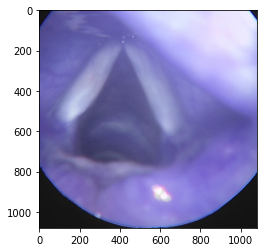

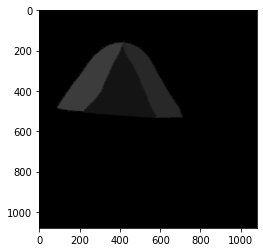

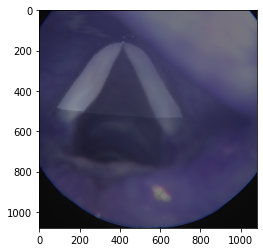

Now looking 3.png


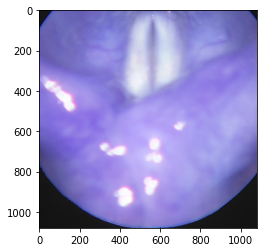

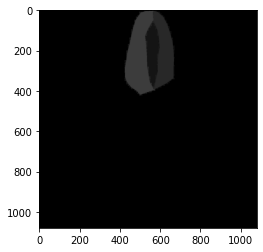

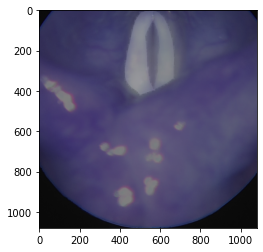

Now looking 6.png


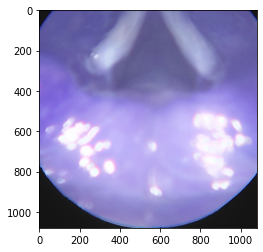

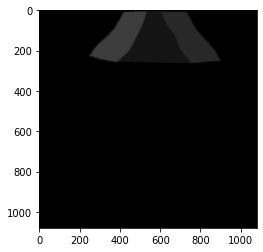

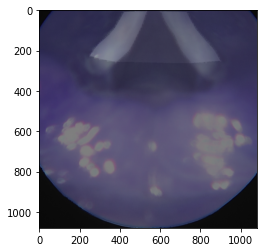

Now looking 7.png


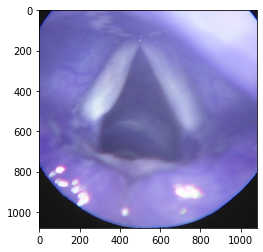

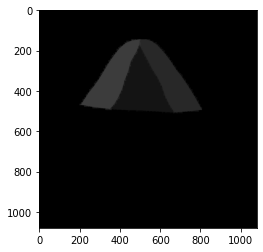

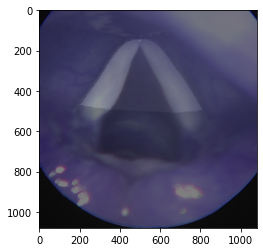

Now looking 10.png


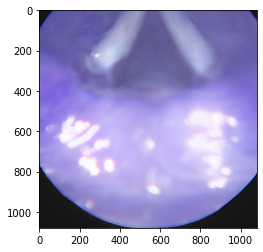

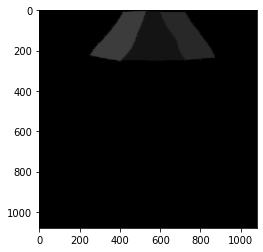

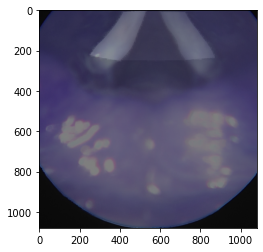

Now looking 11.png


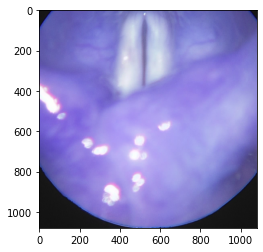

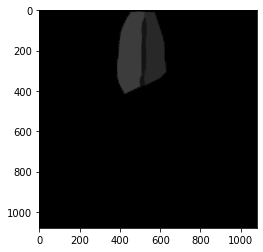

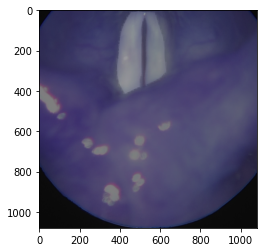

Now looking 14.png


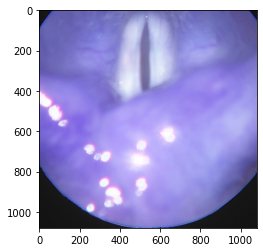

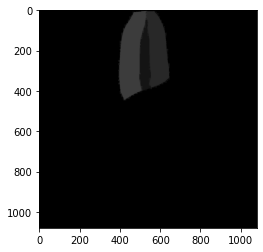

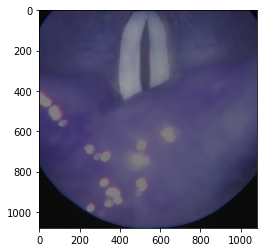

Now looking 15.png


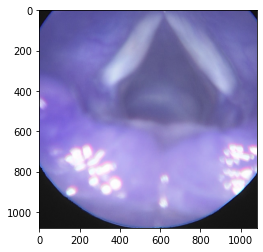

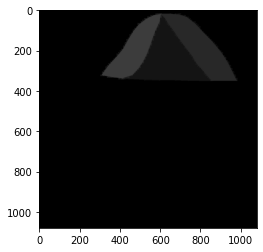

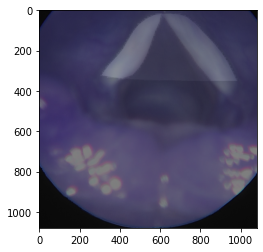

Now looking 18.png


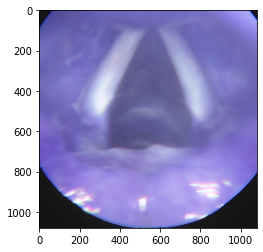

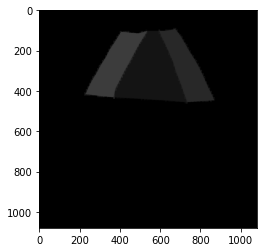

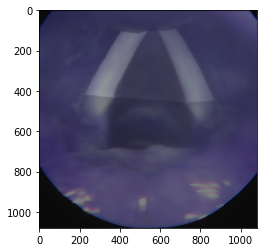

Now looking 19.png


KeyboardInterrupt: ignored

In [ ]:
# mask fit check

mask_DIR = os.path.join(new_DATA_PATH, 'train_1_mask')
jpgs_DIR = os.path.join(new_DATA_PATH, 'train_1_jpgs')


for get_file_name in os.listdir(jpgs_DIR):
  print('Now looking ' + get_file_name)

  mask = cv2.imread(os.path.join(mask_DIR, get_file_name))
  img = cv2.imread(os.path.join(jpgs_DIR, get_file_name))

  plt.imshow(img)
  plt.show()

  mask = mask*20
  plt.imshow(mask)
  plt.show()

  res = cv2.addWeighted(img, 0.5, mask, 0.5, 0)
  plt.imshow(res)
  plt.show()

In [ ]:
def prediction_map(get_list, pred_idx):
  imanopredict = []

  for i in range(0,12):
    imanopredict += [int(np.sum(np.asarray(pred_idx)==i))]

  sumR = 0
  sumL = 0

  for i in range(2, 12, 2):
    sumR += imanopredict[i]
    sumL += imanopredict[i+1]

  print('-'*25)
  for i in range(2, 12, 2):
    print(f'{imanopredict[i]/sumR*100:.2f}% = {get_list[i]}')

  print('-'*25)
  for i in range(3, 12, 2):
    print(f'{imanopredict[i]/sumL*100:.2f}% = {get_list[i]}')

  print('-'*25)

In [ ]:
import pandas as pd

In [ ]:
classescsv_path = os.path.join(new_DATA_PATH, "classes.csv")
classescsv = pd.read_csv(classescsv_path)
classes = list(classescsv['_class'])

In [ ]:
jpgs_DIR = '/content/drive/My Drive/09_research_main/lab_01/data/dataset_C_v_1.4.1/mask'

img_ = np.zeros(10)#622810

for get_file in os.listdir(jpgs_DIR):
  img = cv2.imread(os.path.join(jpgs_DIR, get_file))
  img = np.unique(img)
  img_ = np.concatenate([img_, img])

prediction_map(classes, img_)

-------------------------
19.44% = vfright_normal
22.91% = vfright_rln_R
18.19% = vfright_rln_L
17.52% = vfright_rsln_R
21.94% = vfright_rsln_L
-------------------------
19.42% = vfleft_normal
22.88% = vfleft_rln_R
18.17% = vfleft_rln_L
17.50% = vfleft_rsln_R
22.02% = vfleft_rsln_L
-------------------------


In [ ]:
jpgs_DIR = '/content/drive/My Drive/09_research_main/lab_01/data/dataset_C_v_1.4.1/mask'

img_ = np.zeros(10)#622810

for get_file in os.listdir(jpgs_DIR):
  img = cv2.imread(os.path.join(jpgs_DIR, get_file))
  img = np.unique(img)
  img_ = np.concatenate([img_, img])

img_ = np.unique(img_)
print(img_)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


In [ ]:
jpgs_DIR = '/content/drive/My Drive/09_research_main/lab_01/data/dataset_C_v_1.4.1/mask/0.png'
jpgs_DIR_ = '/content/drive/My Drive/09_research_main/lab_01/data/dataset_C_v_1.4.1/mask/1039.png'


img = cv2.imread(os.path.join(jpgs_DIR, get_file))
img = np.unique(img)

img_ = cv2.imread(os.path.join(jpgs_DIR_, get_file))
img_ = np.unique(img_)

print(type(img[0]))
print(type(img_[0]))


<class 'NoneType'>
<class 'NoneType'>


In [ ]:
jpgs_DIR = '/content/drive/My Drive/09_research_main/lab_01/data/dataset_C_v_1.4.1/mask'

img_ = np.zeros(10)

for get_file in os.listdir(jpgs_DIR):
  img = cv2.imread(os.path.join(jpgs_DIR, get_file))
  img = np.unique(img)
  print(get_file)
  print(img)

40.png
[0 1 2 3]
41.png
[0 1 2 3]
42.png
[0 1 2 3]
43.png
[0 1 2 3]
44.png
[0 1 2 3]
45.png
[0 1 2 3]
46.png
[0 1 2 3]
47.png
[0 1 2 3]
48.png
[0 1 2 3]
49.png
[0 1 2 3]
50.png
[0 1 2 3]
51.png
[0 1 2 3]
52.png
[0 1 2 3]
53.png
[0 1 2 3]
54.png
[0 1 2 3]
55.png
[0 1 2 3]
56.png
[0 1 2 3]
57.png
[0 1 2 3]
58.png
[0 1 2 3]
59.png
[0 1 2 3]
60.png
[0 1 2 3]
61.png
[0 1 2 3]
62.png
[0 1 2 3]
63.png
[0 1 2 3]
64.png
[0 1 2 3]
65.png
[0 1 2 3]
66.png
[0 1 2 3]
67.png
[0 1 2 3]
68.png
[0 1 2 3]
69.png
[0 1 2 3]
70.png
[0 1 2 3]
71.png
[0 1 2 3]
72.png
[0 1 2 3]
73.png
[0 1 2 3]
74.png
[0 1 2 3]
75.png
[0 1 2 3]
76.png
[0 1 2 3]
77.png
[0 1 2 3]
78.png
[0 1 2 3]
79.png
[0 1 2 3]
80.png
[0 1 2 3]
81.png
[0 1 2 3]
82.png
[0 1 2 3]
83.png
[0 1 2 3]
84.png
[0 1 2 3]
85.png
[0 1 2 3]
86.png
[0 1 2 3]
87.png
[0 1 2 3]
88.png
[0 1 2 3]
89.png
[0 1 2 3]
90.png
[0 1 2 3]
91.png
[0 1 2 3]
92.png
[0 1 2 3]
93.png
[0 1 2 3]
94.png
[0 1 2 3]
95.png
[0 1 2 3]
96.png
[0 1 2 3]
97.png
[0 1 2 3]
98.png
[0 1 2 